In [1]:
!pip install torch
!pip install torchvision

    100% |████████████████████████████████| 591.8MB 26kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x618e8000 @  0x7f3b167ff2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 61kB 4.3MB/s 
    100% |████████████████████████████████| 2.0MB 14.2MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


# Reconising Handwritten-Digits

In this notebook I build a simple neural network with multiple layer perceptron that will take 
an image of a handwritten digit and predict what exactly is the number.
I use MNIST dataset which contains 60,000 images of handwritten-digits for training and 10,000 images for testing. The images
are grayscale and of size 28x28 pixels.

I will use PyTorch  to build the model. 
It is a new framework for deep learning that was introduced in the early 2017.
However, even though PyTorch is quite new in compare to TensorFlow, Caffe2 or CNTK,  it has already a pretty big impact in the deep learning community.

## Data Loading
In the following, I first import PyTorch and load the MNIST dataset which is available in the `torchvision` package. I  then load the dataset using `Dataloader`, a nice module to load  dataset available in PyTorch.

In [0]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                              ])
# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=False)

In [7]:
len(trainloader.dataset)

60000

In [8]:
len(testloader.dataset)

10000

## Data Viewing 
Now let us look at the data. It is loaded into `trainloader` and `testloader`where  the batch size is 64 for the training  and 1000 for testing.
 The batch size basically is the number of images I get in one iteration from the data loader.
I set the shuffle mode for the training data to be true and for the testing data to be false.
Basically, by setting the shuffle mode to true, the 
 dataset will get shuffled   every time I start going through the data loader again. 
 
Now I grab the first batch in the testloader to check out the data. 
I first make an iterator with `iter(testloader)` which I will loop later for testing. 
As it is shown below, the first batch is just a tensor with size (1000, 1, 28, 28).  It means we have 1000  images in the batch where each image has 1 color channel (since it is a grayscale) and the size of each image is 28x28 pixels. 


In [25]:
dataiter = iter(testloader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([1000, 1, 28, 28])
torch.Size([1000])


By using matplotlib, I can  show how the images look like.   I plot the first 6 images from the first batch together withs their label.

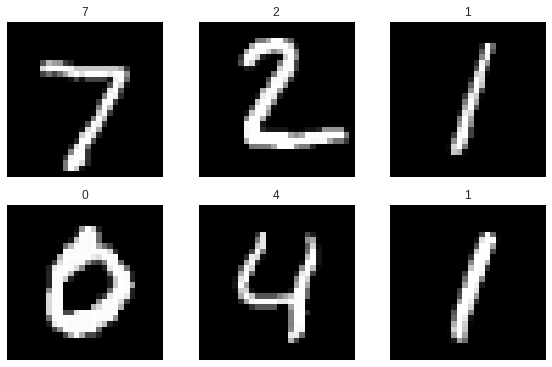

In [26]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(images[i][0], cmap='gray', interpolation='none')
  plt.title("{}".format(labels[i]))
  plt.xticks([])
  plt.yticks([])

## Building the Model

I will build a model by using a simple neural network with two (fully-connected)  hidden layers.
Beside the hidden layers, the model also has an input and output layers.
I will make the model to have 784 units in the input layer. This is because we will consider a grayscale image with 28x28 pixels as an input.
For the output layer I consider 10 units. This is because I want the model to predict the digit shown in the input image, i.e.
whether it is $0, 1, \ldots, 9$.
The model will calculate probabilities of the image being in each of these classes. For the hidden layers, I set the first one to have 128 units
and 64 units for the second one.

For the activation function I choose rectified linear units (or ReLU in short) and I will not use any dropout layer. 

In PyTorch it is very handy to build a neural network. We can use `nn`
 module  that provides an efficient way to build large neural networks. 
 It also automatically initializes the weights and biases of the network.

Since the tensor will be passed sequentially through the layers, I  use `nn.Sequential` as follows.
 

In [0]:
from torch import nn
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

So I have build the model I want. The model will output  the log-probabilities of the input images being $0, 1, \ldots, 9$. 
Now let us see what happens if I pass an image to this model.
I will take the first image on the first batch I have considered before. However, since I have created a model that 
takes as an input image, a one dimension tensor, i.e.
1 x 784, I need todo some preprocessing. This is because the images I have considered before are still two dimension tensors of size 28 x 28. 


In [35]:
images.resize_(64, 1, 784) # resize images into a one dimension vector  
output = model.forward(images[0,:]) # output of the network 
ps = torch.exp(output)  # get the probability of the image being 0,1,...,9

ps

tensor([[0.1064, 0.1128, 0.1088, 0.0876, 0.0873, 0.1222, 0.1060, 0.0819, 0.0937,
         0.0933]], grad_fn=<ExpBackward>)

To see this more clearly,  I create a function to display the image and probablities.

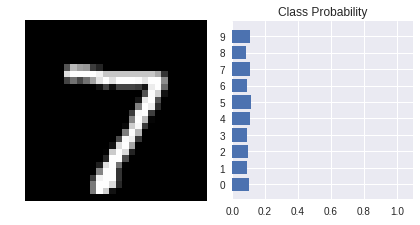

In [29]:
import matplotlib.pyplot as plt
import numpy as np

def view_probs(img, ps):
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze(), cmap='gray')
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    
    plt.tight_layout()


img = images[0]
view_probs(img.view(1, 28, 28), ps)
    

As it is shown, the model was all over the classes with its predictions.
It has no idea what this digit is. 
This is because I have not  trained the model yet, so all the weights are random!

## Training the Model

Now let us train the model. First I initialize the criterion and the optimizer that I will use for the training.
 I will train the network for 5 epochs. In other words,  it will see  the training dataset five times.

In [0]:
criterion = nn.NLLLoss()

from torch import optim
optimizer = optim.SGD(model.parameters(), lr=0.003)

n_epochs = 5

# create list for saving training and testing loss
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(trainloader.dataset) for i in range(n_epochs + 1)]

I check the initial testing loss before the model is being trained, and then train for 5 epochs.

In [37]:
valid_loss = 0
correct = 0
model.eval()
for data, target in testloader:
  # forward pass: compute predicted outputs by passing inputs to the model
  data= data.view(data.shape[0], -1)
  out = model(data)
  # calculate the batch loss
  vloss = criterion(out, target)
  # update average validation loss 
  valid_loss += vloss.item()*data.size(0)
  pred = out.data.max(1, keepdim=True)[1]
  correct += pred.eq(target.data.view_as(pred)).sum()
else:
  test_losses.append(valid_loss/len(testloader.dataset))
  print(f"Test loss: {valid_loss/len(testloader.dataset)}")
  print('Accuracy: {}/{} ({:.0f}%)\n'.format(
    correct, len(testloader.dataset),
    100. * correct / len(testloader.dataset)))

Test loss: 2.317572832107544
Accuracy: 1042/10000 (10%)



In [38]:
for e in range(1, n_epochs+1):
    batch_idx = 0
    running_loss = 0
    valid_loss = 0
    log_interval = 10
    correct = 10
    
# TRAINING THE MODEL
    model.train()
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
        
        batch_idx += 1 
    
        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if batch_idx % log_interval == 0:
           print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(e, batch_idx * len(images), len(trainloader.dataset), 100. * batch_idx / len(trainloader), loss.item()))
           train_losses.append(loss.item())
           train_counter.append((batch_idx*64) + ((e-1)*len(trainloader.dataset)))
    else:
        print(f"Training loss: {running_loss/len(trainloader)}") 

# VALIDATING THE MODEL       
    model.eval()
    for data, target in testloader: 
        # forward pass: compute predicted outputs by passing inputs to the model
        data= data.view(data.shape[0], -1)
        out = model(data)
        # calculate the batch loss
        vloss = criterion(out, target)
        # update average validation loss 
        valid_loss += vloss.item()*data.size(0)
        # keep track accuracy 
        pred = out.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).sum()
    else:
        test_losses.append(valid_loss/len(testloader.dataset))
        print(f"Test loss: {valid_loss/len(testloader.dataset)}")
        print('Accuracy: {}/{} ({:.0f}%)\n'.format(
            correct, len(testloader.dataset),
            100. * correct / len(testloader.dataset)))

Train Epoch: 1 [640/60000 (1%)]	Loss: 2.328422
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.297452
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.287003
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.311182
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.288502
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.284679
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.290592
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.276944
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.273907
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.272866
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.255389
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.284495
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.257609
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.244691
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.244327
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.231143
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.263639
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.230108
Train Epoch: 1 [12160/60000 (20%)]	Loss: 2.206795
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.216717
Train Epoch: 1 [13440/60

Now the model has been trained. It can recognise the handwritten digit without any doubt.

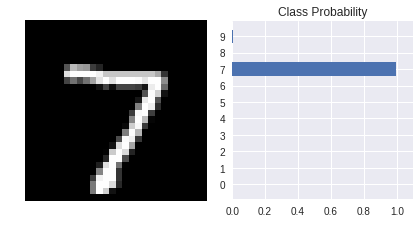

In [39]:
img = img.view(1, 784) 
 
ps_img = torch.exp(model(img))
view_probs(img.view(1, 28, 28), ps_img)

## Model Evaluation

In the beginning, as expected we only get about 10% accuracy. However  after training with  just 5 epochs  by using a very simple neural network we already managed to achieve 89% accuracy. 

Here I plot the training curve.  By looking at it, it seems that training the model for 5 epochs is the best thing I can do.  This is because continue training for   more epochs probably will make the model deals with overfitting issues.

Text(0,0.5,'negative log likelihood loss')

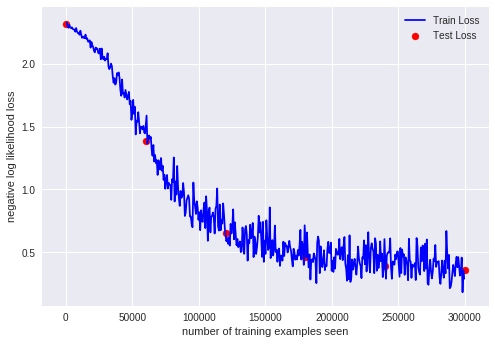

In [40]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss','Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
